In [1]:
import MGBlurr.blurring as blur
from MGTomo.utils import mylog, mydiv, myexp
import MGTomo.functions as fcts
from MGTomo.optimize import armijo_linesearch, box_bounds

from MGTomo.gridop import RBox as R, PBox as P

from MGTomo import gridop

import time
import numpy as np
import torch
from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 
from skimage import data
from skimage.transform import resize

## KL(Ax,b) with Burg entropy.

On $[0,1]^n$, using Fermi-Dirac entropy for scaled boxes, Lipschiz constant is $\vert A \vert_1 = 1$ in the case of Gaussian filter. 

In [16]:
N = 511
max_levels = 3
maxIter = [1,1,1,32,64,123]
kernel_size = 27
sigma = 5
poisson_lbd = 1000

# load image
# x_orig = data.camera()
# x_orig = resize(x_orig, (N,N), anti_aliasing = False)
# x_torch = torch.tensor(x_orig, requires_grad = True)

# from astropy.io import fits
# from astropy.utils.data import get_pkg_data_filename
# filename = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')
# hdul = fits.open(filename)
# image_data = hdul[0].data


# resized_image_np = np.array(resized_image)/255

# x_orig = resize(image_data, (N, N), anti_aliasing = False)

from PIL import Image

image = Image.open('tycho-crater.png').convert('L')
image_np = np.array(image)

resized_image = image.resize((N, N))
x_orig = np.array(resized_image)/255
x_torch = torch.tensor(x_orig, requires_grad = True)


A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [torch.poisson(A[0](x_torch)*poisson_lbd)/poisson_lbd]
#b = [A[0](x_torch)]

P_nonzero = []

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))
    fine_dim = coarse_dim

In [3]:
A[0]

In [4]:
def GD_check(x, b, fh):
    const = torch.sum((1-b)/b)/torch.numel(b)*tau[0]
    xplus = fcts.BSMART(fh, x, 1.)
    LHS = fcts.kl_distance_no_matrix(xplus, x)
    fx = fh(x)
    if not torch.any(LHS >= const * fx):
        print(LHS - const * fx)

    return


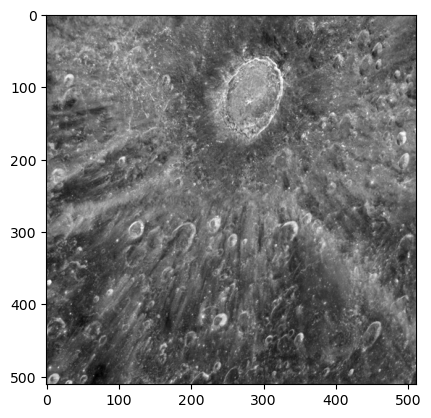

In [4]:
plt.imshow(x_orig, cmap='gray')

In [17]:
plt.imsave('blur_27_5_1000.png', b[0].detach(), cmap='gray')

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])
#tau = [0.5 * torch.reciprocal(matrix_norm(bi, ord = 1)) for bi in b]
tau0 = 0.5
tau = [tau0]*(max_levels+1)
P_inf = 1

In [7]:
tau

[0.5, 0.5, 0.5, 0.5]

In [8]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    with torch.no_grad():
        gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
        if gcond:
            if y_last is not None:
                y_diff_norm = matrix_norm(y_last - y)
                y_norm = matrix_norm(y)
                return (y_diff_norm >= eta * y_norm)
            return True
        else:
            return False

In [9]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.45, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0 = y.detach().requires_grad_(True)
    fhy0 = fh(y)
    fhy0.backward(retain_graph = True)
    #fhy0.backward()
    grad_fhy0 = y.grad.clone()
    y.grad = None
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y.clone().detach()
    
        x0 = x.clone().detach().requires_grad_(True)
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad = None

        kappa = R(grad_fhy0) - grad_fHx0
        del grad_fHx0

        with torch.no_grad():
            psi = lambda x: fH(x) + torch.sum(kappa * x)
            lH, uH = box_bounds(y, x, P_inf, lh, uh, P_nonzero[l])

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l+1]):
            #x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.detach().requires_grad_(True)
            del val
            x.grad = None
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1)

        d = P(x-x0)
        z, _ = armijo_linesearch(fh, y0, d)
        y = z.detach().requires_grad_(True)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        #y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.detach().requires_grad_(True)
        del yval
        y.grad = None
    return y, last_pts

In [ ]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

norm_fval_SL = []
norm_fval_SL.append(torch.tensor(1.))

fhw = fh(w0)
w0.retain_grad()
fhw.backward(retain_graph=True)
Gw0 = matrix_norm(w0.grad)

iteration_times_SL = []
iteration_times_SL.append(0)

logv_new = mylog((w0 - lh)) - mylog((uh - w0))

norm_grad_SL = []
norm_grad_SL.append(torch.tensor(1.))

for i in range(5):

    iteration_start_time_SL = time.time()  # Start timing for this iteration
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, tau[0], lh, uh)
    iteration_end_time_SL = time.time()  # End timing for this iteration
    
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    iteration_times_SL.append(iteration_time_SL)
    
    w0 = val.clone().detach().requires_grad_(True)

    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    fval = fh(w0)
    fval.backward(retain_graph=True)
    norm_grad_SL.append((matrix_norm(w0.grad)/Gw0).item())
    norm_fval_SL.append((fval/fhw).item())
    
    print(f"Iteration {i}: {fval} - Time: {iteration_time_SL:.6f} seconds")

overall_time_SL = sum(iteration_times_SL)

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]

Iteration 0: 57323.27729518531 - Time: 6.413798 seconds


KeyboardInterrupt: 

In [11]:
P_inf = 1
a = []
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

norm_fval = []
norm_fval.append(torch.tensor(1.))

fhz = fh(z0)

fhz.backward(retain_graph=True)
Gz0 = matrix_norm(z0.grad)
z0.grad = None

norm_grad = []
norm_grad.append(torch.tensor(1.))

iteration_times_ML = []
iteration_times_ML.append(0)

for i in range(2):
    
    iteration_start_time_ML = time.time()
    #GD_check(z0, b[0], fh)
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts)
    iteration_end_time_ML = time.time()
    
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML
    iteration_times_ML.append(iteration_time_ML)

    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    fval = fh(z0)
    norm_fval.append((fval/fhz).item())
    fval.backward(retain_graph=True)
    norm_grad.append((matrix_norm(z0.grad)/Gz0).item())
    z0.grad = None
    print(f"Iteration {i}: {fval} - Time: {iteration_time_ML:.6f} seconds")

overall_time_ML = sum(iteration_times_ML)

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 0: 39411.91921534396 - Time: 42.727517 seconds


KeyboardInterrupt: 

In [ ]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("MLO"):
        MLO_box(fh, z0, lh, uh, last_pts)

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        29.09%       20.267s       100.00%       69.676s       69.676s             1  
autograd::engine::evaluate_function: ConvolutionBack...         0.00%     401.987us        30.02%       20.914s     426.814ms            49  
                                   ConvolutionBackward0         0.00%     389.865us        30.02%       20.913s     426.806ms            49  
                             aten::convolution_backward        10.65%        7.420s        30.01%       20.913s     426.798ms            49  
      

In [ ]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
logv_new = mylog((w0 - lh)) - mylog((uh - w0))
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("SL"):
        fcts.BSMART_general(fh, w0, logv_new, tau[0], lh, uh)

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                     SL         0.81%      49.417ms       100.00%        6.133s        6.133s             1  
autograd::engine::evaluate_function: ConvolutionBack...         0.00%      33.447us        96.85%        5.939s        2.970s             2  
                                   ConvolutionBackward0         0.15%       8.967ms        96.85%        5.939s        2.970s             2  
                             aten::convolution_backward        23.67%        1.451s        96.70%        5.930s        2.965s             2  
      

In [ ]:
overall_time_ML = sum(iteration_times_ML)

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

Overall time for all iterations: 87.636474 seconds


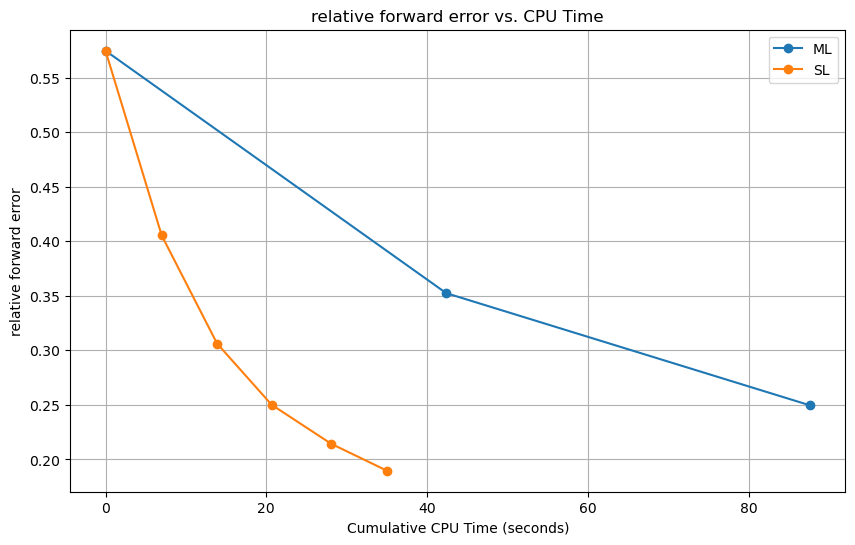

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, rel_f_err, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, rel_f_err_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('relative forward error')
plt.title('relative forward error vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

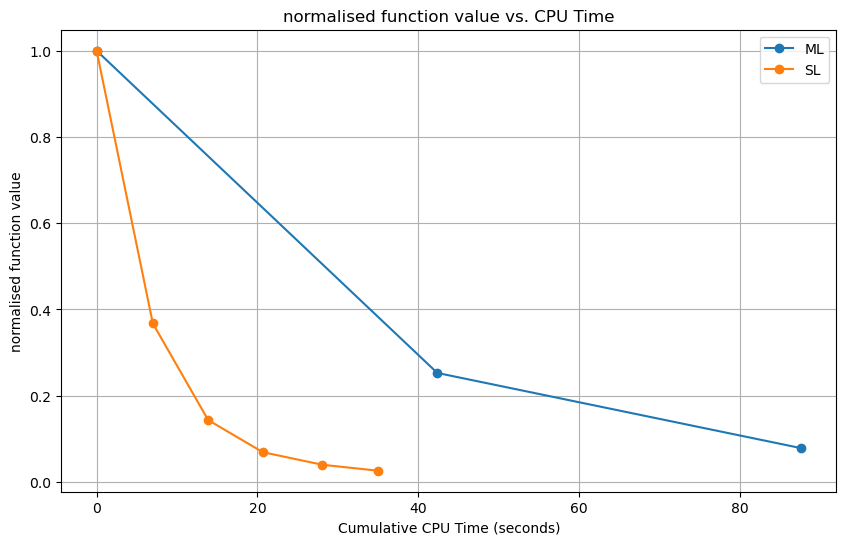

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, norm_fval, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, norm_fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('normalised function value')
plt.title('normalised function value vs. CPU Time')
plt.grid(True)
plt.legend()

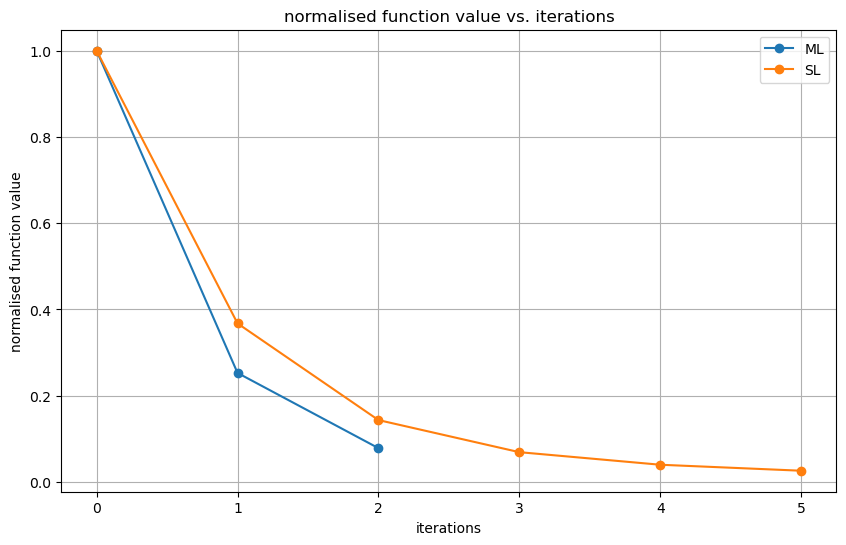

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(norm_fval)), norm_fval, marker='o', linestyle='-', label = 'ML')
plt.plot(range(len(norm_fval_SL)), norm_fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('iterations')
plt.ylabel('normalised function value')
plt.title('normalised function value vs. iterations')
plt.grid(True)
plt.legend()
plt.show()